Select Control DeepLabCut CSV Files
Select Control BORIS CSV Files
Processing files for 2A: 2A_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2A.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2A_behavior_binned.csv
Saved displacement data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2A_displacement_binned.csv
Processing files for 2B: 2B_8_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2B.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2B_behavior_binned.csv
Saved displacement data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2B_displacement_binned.csv
Processing files for 2E: 2E_7_bottomDLC_Resnet50_gridwalking_202409Nov19shuffle1_snapshot_100.csv and 2E.csv
Saved behavior data to D:/works/Data_analysis/projects/grid_walking/2024_09/result\Control_2E_behavior_binned.csv
Saved displacement d

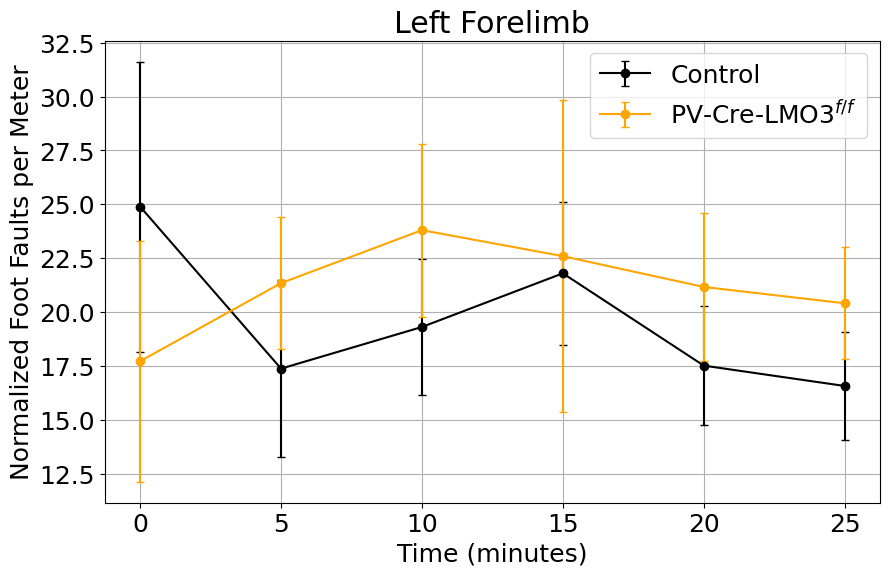

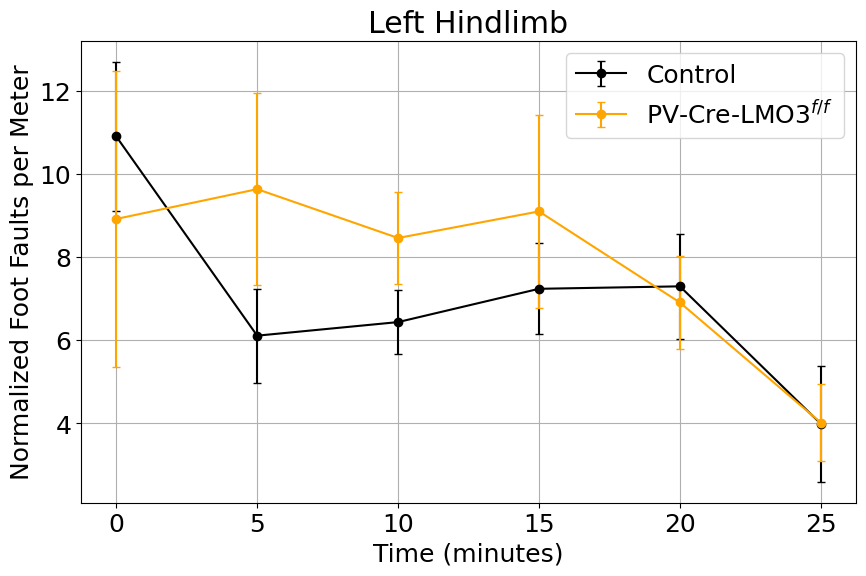

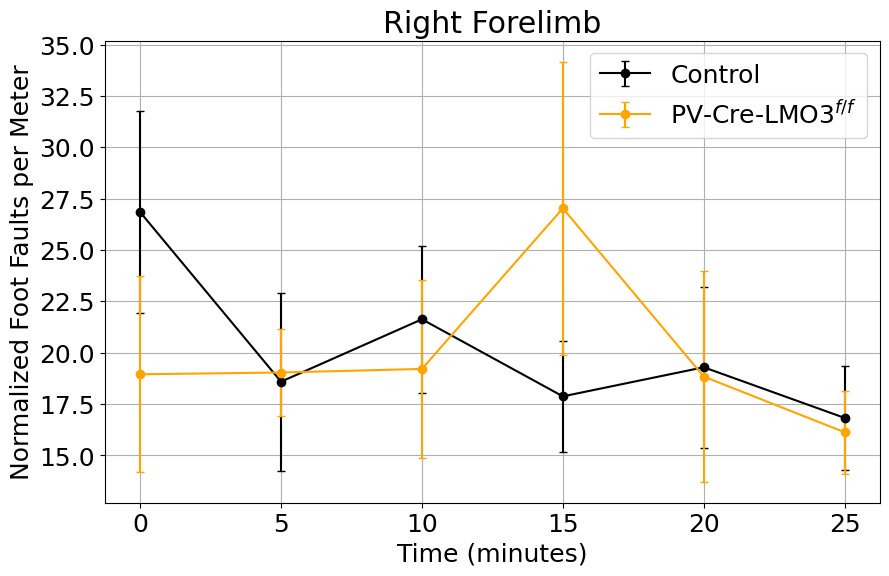

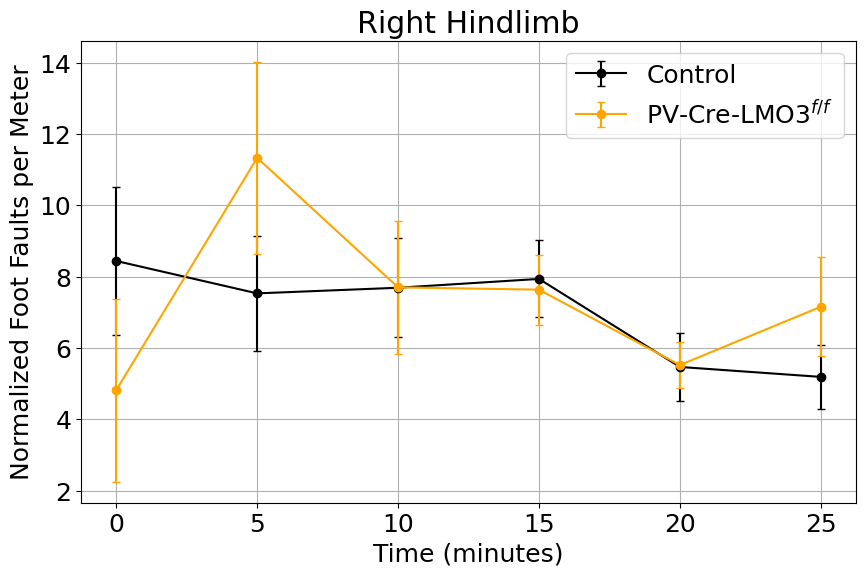

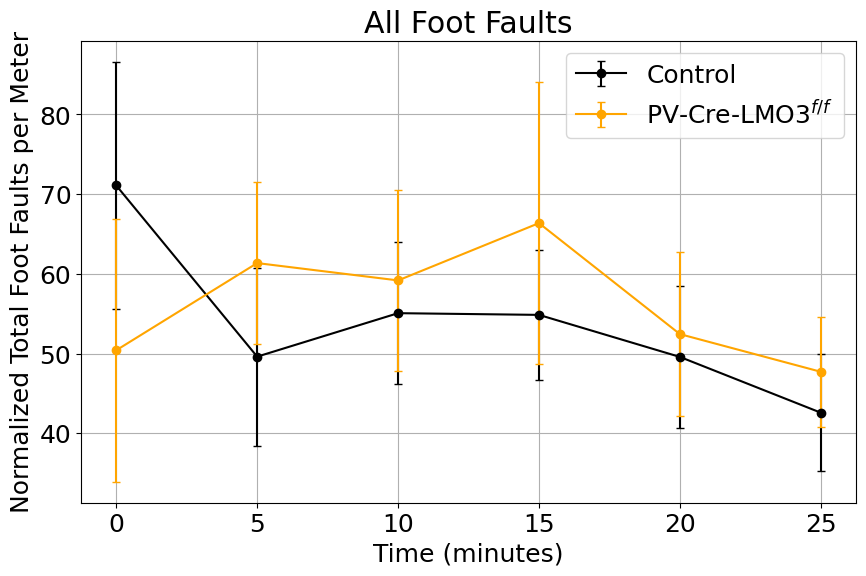

Statistical results saved to: D:/works/Data_analysis/projects/grid_walking/2024_09/result\statistical_results_with_total.csv


In [5]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog
import os
from scipy.stats import ranksums  # Wilcoxon rank sum test
from matplotlib.cm import tab20
from matplotlib.colors import to_hex


def load_deeplabcut_data(file_path):
    """Load and preprocess DeepLabCut data from a CSV file."""
    try:
        deeplabcut_data = pd.read_csv(file_path)
        # Clean data
        deeplabcut_cleaned = deeplabcut_data.iloc[2:].copy()
        deeplabcut_cleaned.columns = ['frame', 'x', 'y', 'likelihood']
        deeplabcut_cleaned = deeplabcut_cleaned[['frame', 'x', 'y', 'likelihood']].astype(float)
        deeplabcut_cleaned['frame'] = deeplabcut_cleaned['frame'].astype(int)
        return deeplabcut_cleaned
    except Exception as e:
        print(f"Error loading DeepLabCut file {file_path}: {e}")
        return None
    
def process_deeplabcut_files(pixel_to_cm, bin_duration, frame_rate):
    """Process multiple DeepLabCut files and return binned displacement data."""
    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select DeepLabCut CSV Files")
    if not file_paths:
        print("No DeepLabCut files selected. Exiting.")
        return []

    displacement_binned_list = []
    for file_path in file_paths:
        data = load_deeplabcut_data(file_path)
        if data is None:
            continue
        data = smooth_deeplabcut_data(data)
        data = calculate_displacement(data, pixel_to_cm)
        displacement_binned = bin_displacement_data(data, bin_duration, frame_rate)
        displacement_binned_list.append(displacement_binned)

    return displacement_binned_list

def process_boris_files(bin_duration):
    """Process multiple BORIS files and return binned behavior data."""
    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()

    file_paths = filedialog.askopenfilenames(title="Select BORIS CSV Files")
    if not file_paths:
        print("No BORIS files selected. Exiting.")
        return []

    behavior_binned_list = []
    for file_path in file_paths:
        data = load_boris_data(file_path)
        if data is None:
            continue
        behavior_binned = bin_behavior_data(data, bin_duration)
        behavior_binned_list.append(behavior_binned)

    return behavior_binned_list



def smooth_deeplabcut_data(data, sigma=2):
    """Apply Gaussian smoothing to the x and y coordinates."""
    data['x_smooth'] = gaussian_filter1d(data['x'], sigma=sigma)
    data['y_smooth'] = gaussian_filter1d(data['y'], sigma=sigma)
    return data


def calculate_displacement(data, pixel_to_cm):
    """Calculate displacement between consecutive frames."""
    data['dx'] = data['x_smooth'].diff().fillna(0)
    data['dy'] = data['y_smooth'].diff().fillna(0)
    data['displacement'] = np.sqrt(data['dx']**2 + data['dy']**2) * pixel_to_cm
    return data


def bin_displacement_data(data, bin_duration, frame_rate):
    """Bin displacement data by time intervals."""
    data['time'] = data['frame'] / frame_rate
    data['time_bin'] = (data['time'] // bin_duration).astype(int)
    displacement_binned = data.groupby('time_bin')['displacement'].sum().reset_index()
    displacement_binned.columns = ['time_bin', 'total_displacement']
    return displacement_binned


def load_boris_data(file_path):
    """Load and preprocess BORIS behavior data from a CSV file."""
    try:
        with open(file_path, 'r') as f:
            boris_lines = f.readlines()

        behavior_header = "Time,Media file path,Total length,FPS,Subject,Behavior,Behavioral category,Comment,Status\n"
        start_line = boris_lines.index(behavior_header) + 1

        boris_behavior_full_data = pd.read_csv(file_path, skiprows=start_line, header=None)
        boris_behavior_cleaned = boris_behavior_full_data[[0, 5]].copy()
        boris_behavior_cleaned.columns = ['time', 'behavior']
        boris_behavior_cleaned['time'] = pd.to_numeric(boris_behavior_cleaned['time'], errors='coerce')
        boris_behavior_cleaned = boris_behavior_cleaned.dropna()
        return boris_behavior_cleaned
    except Exception as e:
        print(f"Error loading BORIS file {file_path}: {e}")
        return None


def bin_behavior_data(data, bin_duration):
    """Bin BORIS behavior data by time intervals."""
    data['time_bin'] = (data['time'] // bin_duration).astype(int)
    behavior_binned = data.groupby(['time_bin', 'behavior']).size().unstack(fill_value=0).reset_index()
    return behavior_binned


def normalize_behavior_by_displacement(behavior_binned, displacement_binned):
    """Normalize behavior counts by displacement for each bin."""
    # Merge the two dataframes on 'time_bin' to ensure alignment
    merged = pd.merge(behavior_binned, displacement_binned, on='time_bin', how='inner')

    # Identify behavior columns dynamically
    behavior_columns = [col for col in behavior_binned.columns if col != 'time_bin']

    # Normalize behavior counts by displacement
    normalized_behavior = merged.copy()
    for behavior in behavior_columns:
        normalized_behavior[behavior] = np.where(
            merged['total_displacement'] > 0,
            merged[behavior] *1000 / merged['total_displacement'],
            np.nan  # Handle zero displacement bins
        )
    
    # Drop 'total_displacement' after normalization
    normalized_behavior = normalized_behavior.drop(columns=['total_displacement'])
    return normalized_behavior


def group_mean_and_sem(data_list):
    """Calculate group mean and SEM for a list of normalized dataframes."""
    combined_data = pd.concat(data_list, axis=0)
    group_mean = combined_data.groupby('time_bin').mean()
    group_sem = combined_data.groupby('time_bin').sem()
    return group_mean, group_sem


def plot_with_stats(control_mean, control_sem, experiment_mean, experiment_sem, 
                    control_data_list, experiment_data_list, bin_duration, behaviors, output_dir):
    """Plot group data for control and experiment groups with statistical test results."""
    time_bins = control_mean.index * bin_duration / 60  # Convert time_bin to minutes

    # Combine all individual mouse data into a single dataframe for control and experiment
    control_data = pd.concat(control_data_list, axis=0)
    experiment_data = pd.concat(experiment_data_list, axis=0)

    # Generate a color map for behaviors
    cmap = tab20.colors
    behavior_colors = {behavior: cmap[i % len(cmap)] for i, behavior in enumerate(behaviors)}

    # Initialize a DataFrame to store statistical test results
    stats_results = []

    # Plot each behavior separately
    for behavior in behaviors:
        if behavior not in control_mean.columns or behavior not in experiment_mean.columns:
            print(f"Behavior {behavior} missing in one group. Skipping.")
            continue

        # Get the color for the current behavior
        behavior_color = to_hex(behavior_colors[behavior])

        # Create a new figure for each behavior
        plt.figure(figsize=(10, 6))

        # Plot control group
        plt.errorbar(
            time_bins,
            control_mean[behavior],
            yerr=control_sem[behavior],
            label=f"Control",
            capsize=3,
            marker='o',
            color='black',
            linestyle='-'
        )

        # Plot experiment group
        plt.errorbar(
            time_bins,
            experiment_mean[behavior],
            yerr=experiment_sem[behavior],
            label="PV-Cre-LMO3$^{f/f}$",
            capsize=3,
            marker='o',
            color='orange',
            linestyle='-'
        )

        # Perform statistical test for each time bin
        for time_bin in control_mean.index:
            control_values = control_data[control_data['time_bin'] == time_bin][behavior].dropna()
            experiment_values = experiment_data[experiment_data['time_bin'] == time_bin][behavior].dropna()

            if len(control_values) > 0 and len(experiment_values) > 0:
                stat, p_value = ranksums(control_values, experiment_values)
                stats_results.append({
                    "Behavior": behavior,
                    "Time Bin (minutes)": time_bin * bin_duration / 60,
                    "p-value": p_value
                })
                if p_value < 0.05:  # Add asterisks for significant results
                    y_max = max(control_mean[behavior].loc[time_bin], experiment_mean[behavior].loc[time_bin])
                    plt.text(time_bin * bin_duration / 60, y_max + 0.05 * y_max, 
                             '*', ha='center', va='bottom', fontsize=12, color='red')
                    
        if behavior == 'R_fl':
            behavior_name = 'Right Forelimb'
        elif behavior == 'L_fl':
            behavior_name = 'Left Forelimb'
        elif behavior == 'R_hl':
            behavior_name = 'Right Hindlimb'
        elif behavior == 'L_hl':
            behavior_name = 'Left Hindlimb'
        
        # Add titles, labels, and legend for each behavior
        plt.title(behavior_name)
        plt.xlabel("Time (minutes)")
        plt.ylabel("Normalized Foot Faults per Meter")
        plt.legend()
        plt.grid()
        plt.show()

    # Combine all behaviors into a single total count
    control_total = control_mean[behaviors].sum(axis=1)
    experiment_total = experiment_mean[behaviors].sum(axis=1)
    control_total_sem = control_sem[behaviors].sum(axis=1)
    experiment_total_sem = experiment_sem[behaviors].sum(axis=1)

    # Plot combined behaviors
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        time_bins,
        control_total,
        yerr=control_total_sem,
        label="Control",
        capsize=3,
        marker='o',
        color='black',
        linestyle='-'
    )
    plt.errorbar(
        time_bins,
        experiment_total,
        yerr=experiment_total_sem,
        label="PV-Cre-LMO3$^{f/f}$",
        capsize=3,
        marker='o',
        color='orange',
        linestyle='-'
    )

    # Perform statistical test for combined behaviors
    for time_bin in control_mean.index:
        control_values = control_data[control_data['time_bin'] == time_bin][behaviors].sum(axis=1).dropna()
        experiment_values = experiment_data[experiment_data['time_bin'] == time_bin][behaviors].sum(axis=1).dropna()

        if len(control_values) > 0 and len(experiment_values) > 0:
            stat, p_value = ranksums(control_values, experiment_values)
            stats_results.append({
                "Behavior": "Total",
                "Time Bin (minutes)": time_bin * bin_duration / 60,
                "p-value": p_value
            })
            if p_value < 0.05:  # Add asterisks for significant results
                y_max = max(control_total.loc[time_bin], experiment_total.loc[time_bin])
                plt.text(time_bin * bin_duration / 60, y_max + 0.05 * y_max, 
                         '*', ha='center', va='bottom', fontsize=12, color='red')

    plt.title("All Foot Faults")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Normalized Total Foot Faults per Meter")
    plt.legend()
    plt.grid()
    plt.show()

    # Save statistical results to CSV
    stats_results_df = pd.DataFrame(stats_results)
    stats_results_file = os.path.join(output_dir, "statistical_results_with_total.csv")
    stats_results_df.to_csv(stats_results_file, index=False)
    print(f"Statistical results saved to: {stats_results_file}")




def process_group_files(pixel_to_cm, bin_duration, frame_rate, group_name, output_dir):
    """Process multiple files for a specific group (control or experiment) with file matching."""
    print(f"Select {group_name} DeepLabCut CSV Files")
    dlc_files = filedialog.askopenfilenames(title=f"Select {group_name} DeepLabCut CSV Files")
    print(f"Select {group_name} BORIS CSV Files")
    boris_files = filedialog.askopenfilenames(title=f"Select {group_name} BORIS CSV Files")

    if len(dlc_files) != len(boris_files):
        print(f"Error: Mismatch in number of DLC and BORIS files for {group_name}. Exiting.")
        return []

    # Match files based on identifiers in their filenames (e.g., "Mouse1", "Mouse2")
    matched_files = []
    for dlc_file in dlc_files:
        mouse_id = os.path.basename(dlc_file).split('_')[0]  # Extract identifier (e.g., "Mouse1")
        matching_boris = next((f for f in boris_files if mouse_id in os.path.basename(f)), None)
        if matching_boris:
            matched_files.append((dlc_file, matching_boris))
        else:
            print(f"Warning: No matching BORIS file found for {dlc_file}. Skipping.")

    # Process each matched pair
    normalized_behavior_list = []
    for idx, (dlc_file, boris_file) in enumerate(matched_files):
        mouse_id = os.path.basename(dlc_file).split('_')[0]  # Extract the Mouse ID from filename
        print(f"Processing files for {mouse_id}: {os.path.basename(dlc_file)} and {os.path.basename(boris_file)}")

        # Process DLC file
        displacement_data = load_deeplabcut_data(dlc_file)
        if displacement_data is None:
            continue
        displacement_data = smooth_deeplabcut_data(displacement_data)
        displacement_data = calculate_displacement(displacement_data, pixel_to_cm)
        displacement_binned = bin_displacement_data(displacement_data, bin_duration, frame_rate)

        # Process BORIS file
        behavior_data = load_boris_data(boris_file)
        if behavior_data is None:
            continue
        behavior_binned = bin_behavior_data(behavior_data, bin_duration)

        # Save raw binned data with mouse ID in the filename
        behavior_file = os.path.join(output_dir, f"{group_name}_{mouse_id}_behavior_binned.csv")
        displacement_file = os.path.join(output_dir, f"{group_name}_{mouse_id}_displacement_binned.csv")

        behavior_binned.to_csv(behavior_file, index=False)
        displacement_binned.to_csv(displacement_file, index=False)
        print(f"Saved behavior data to {behavior_file}")
        print(f"Saved displacement data to {displacement_file}")

        # Normalize behavior by displacement
        normalized_behavior = normalize_behavior_by_displacement(behavior_binned, displacement_binned)
        normalized_behavior['time_bin'] = behavior_binned['time_bin']
        normalized_behavior_list.append(normalized_behavior)

    return normalized_behavior_list





def main():
    PIXEL_TO_CM = 40 / 480  # Conversion factor from pixels to cm
    FRAME_RATE = 30  # Frames per second
    BIN_DURATION = 5 * 60  # Bin duration in seconds (5 minutes)

    root = tk.Tk()
    root.attributes('-topmost', True)
    root.withdraw()

    plt.rcParams.update({'font.size': 18})

    # Choose output directory for results
    output_dir = filedialog.askdirectory(title="Select Directory to Save Results")
    if not output_dir:
        print("No output directory selected. Exiting.")
        return

    # Process control and experiment groups
    control_data = process_group_files(PIXEL_TO_CM, BIN_DURATION, FRAME_RATE, "Control", output_dir)
    experiment_data = process_group_files(PIXEL_TO_CM, BIN_DURATION, FRAME_RATE, "Experiment", output_dir)

    if not control_data or not experiment_data:
        print("Data processing failed for one or both groups.")
        return

    # Calculate group mean and SEM
    control_mean, control_sem = group_mean_and_sem(control_data)
    experiment_mean, experiment_sem = group_mean_and_sem(experiment_data)

    # Extract all behaviors for plotting
    behaviors = control_mean.columns

    # Plot with statistical comparisons and save results
    plot_with_stats(control_mean, control_sem, experiment_mean, experiment_sem, 
                    control_data, experiment_data, BIN_DURATION, behaviors, output_dir)


if __name__ == "__main__":
    main()
